In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import os
import re
import ast
import math
import time
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style

from glob import glob
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag

import tensorflow as tf
import tensorflow.keras as K
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
from tensorflow.keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D 
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten, Activation

warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Reshape, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.initializers import RandomNormal
from keras.backend import clear_session
np.random.seed(0)

Using TensorFlow backend.


In [5]:
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# 每次都要改 依照每次要 generate 的部分
# 若 label 名稱有空格 加底線 ex coffee_cup
correct_label = "The_Great_Wall_of_China"

# 每次都要改 依照每次要 generate 的部分
# 若 label 名稱有空格 不加底線 ex train/coffee cup.csv
input_csv_file = '/content/gdrive/My Drive/input/train/The Great Wall of China.csv'

# 每次都要改 依照每次要 generate 的部分
# 這個要自己先在 google drive 中創建好資料夾
# 最後記得 加上 "/"
# 若 label 名稱有空格 加底線 ex Gan_model/coffee_cup/

dir_to_save_model = "/content/gdrive/My Drive/Colab Notebooks/GANmodels/"

num_examples = 100

# 要 用來 test 的 model  
model_to_load = '/content/gdrive/My Drive/Colab Notebooks/classifier_for_ensemble/Benny2.model'


In [0]:
# 我們的 input 與 output 的 size
img_h, img_w = 64, 64

# 每個class 的 csv 檔中我們要挑幾張圖出來當 traindata
ims_per_class = 200000

# 在畫圖時的線的粗度 10 是因為我之前縮成 32*32 要粗一點才不會因為縮小而直接不見
# 現在應該可以調小一點 因為現在是 64*64
width = 10

# load model classification 用的
def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

# 也是load model 用的 因為當初的 classification model 有用到這個 和 top_3_accuracy 這兩個 customize function
# 必須在此宣告 才能成功load model

# 這個 function 像是把 csv 裡的點 畫在一張256*256的 "白色" 畫布上 ，將各點用 "黑線" 連接，在 "resize" 回 64*64
# 出來的圖就是 沒東西是255 有東西是0 然後除以 255 做 normalize 使值是 0 跟 1
# 0 => 有沒東西   1 => 沒東西

def draw_it(strokes): 
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width = width)
    image = image.resize((img_h, img_w))
    return np.array(image)/255.

# load model
model = tf.keras.models.load_model(model_to_load, custom_objects={'top_3_accuracy': top_3_accuracy})

# 30 cagetroies we have learned in classification
# 這個對應表 與 當初 train classification 的 對應表 必須一樣
numstonames = {0: 'banana', 1: 'bandage', 2: 'bear', 3: 'bed', 4: 'bee', 5: 'belt', 6: 'cactus', 7: 'cake', 8: 'coffee_cup', 9: 'door', 10: 'fork', 11: 'giraffe', 12: 'hand', 13: 'key', 14: 'laptop', 15: 'light_bulb', 16: 'marker', 17: 'paintbrush', 18: 'popsicle', 19: 'raccoon', 20: 'rain', 21: 'roller_coaster', 22: 'snail', 23: 'spoon', 24: 'swan', 25: 'The_Great_Wall_of_China', 26: 'toaster', 27: 'train', 28: 'whale', 29: 'wine_bottle'}
               

In [0]:
# 功能與上面的 draw_it 一樣， 不同的是最後 normalize 的方式 最後我們選擇
# 有東西是1 沒東西是 -1
# 會這樣調是因為我改的這個 DCGAN 的 model 原本的 input 的格式就是這樣，我就直接改過來了

def draw_it_(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width = width)
    image = image.resize((img_h, img_w))
    return np.array(image)/-127.5 + 1

In [39]:
#讀CSV檔
train = pd.read_csv(input_csv_file, nrows=ims_per_class)

#將csv檔的點連成線
imagebag = bag.from_sequence(train.drawing.values).map(draw_it_) 
trainarray = np.array(imagebag.compute())

# 將shape 調成 (張數, input_height, input_width, 1)
# 這個格式 才能丟進去 train
X_train = trainarray.reshape(trainarray.shape[0], img_h, img_w, 1)

print(X_train.shape)


(153957, 64, 64, 1)


[[[-1.]
  [-1.]
  [-1.]
  ...
  [ 1.]
  [ 1.]
  [ 1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [ 1.]
  [ 1.]
  [ 1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [ 1.]
  [ 1.]
  [-1.]]

 ...

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]]


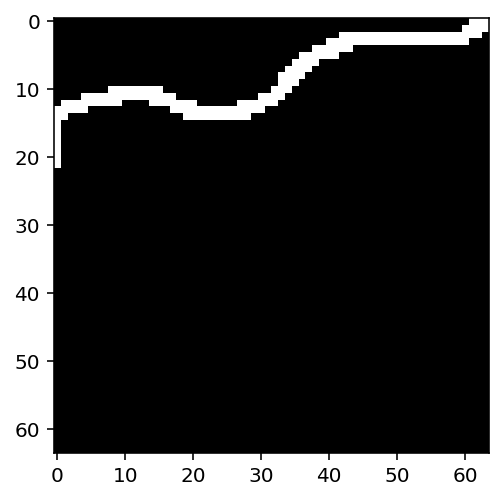

In [40]:
#隨便取一張來顯示
# 可以發現有圖的是 1 背景是 -1
print(X_train[80])
a = X_train[80].reshape(img_h, img_w)
plt.imshow(a, cmap='gray')


In [0]:
class DCGAN():
  
  def __init__(self):
      self.img_rows = img_h
      self.img_cols = img_w
      self.img_shape = (self.img_rows, self.img_cols, 1)

      # 這個 100 是 generator 會用到的結構參數
      # 好像大家都是設定 100 ?
      # https://kknews.cc/zh-tw/news/n5glnm2.html 這個網址快速了解一下 DCGAN 的 模型架構
      self.latent_dim = 100

      # Adam 是很常用的optimizer ， 但我也沒特別研究
      # 若有時間可以調看看後面的參數 說不定結果會比較好
      self.optimizer = Adam(0.0002, 0.5)

      # Build and compile the discriminator
      self.discriminator = self.build_discriminator()
      self.discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)

      # Build and compile the generator
      self.generator = self.build_generator()
      self.generator.compile(loss='binary_crossentropy', optimizer=self.optimizer)

      self.gan = self.build_GAN()
  
  def build_GAN(self):

      # generator 生成圖片給 discriminator 判斷（結果會顯示 是真的圖片(train data) 還是假的(generator出來的)）
      # 由 discriminator 的 output 結果， feedback 給 generator，生成更像 train data 的圖片
      # 由這樣一直的訓練， D 跟 G 的能力都會變強，只是這次我們更著重在 G 的部分

      self.discriminator.trainable = False
      gan_input = Input(shape=(self.latent_dim,))
      img = self.generator(gan_input)
      
      gan_output = self.discriminator(img)
      gan = Model(gan_input, gan_output, name='GAN')
      gan.compile(loss='binary_crossentropy', optimizer=self.optimizer)
      gan.summary()
      
      return gan
    
  def build_generator(self):
      
      # 原本的 model 只有 一個 Dense 跟 兩個 upsample~BatchNormaliztion 的過程
      # 我把 Dense 從 7 改 8 (因為 7 適合原本的 28*28 我改成 8 讓他變成適合 32*32)
      # 標記起來的地方 是為了讓他從 32*32 變 64*64 ，多做一次的 upsample
      # 可以比對 原本網路的程式碼 來比較一下
      # 注意看執行後的每層layer 的 input/ output 數量變化 

      generator = Sequential()
      generator.add(Dense(128 * 8 * 8, activation="relu", input_dim=self.latent_dim))
      generator.add(Reshape((8, 8, 128)))
      generator.add(BatchNormalization(momentum=0.8))
      
      generator.add(UpSampling2D())
      generator.add(Conv2D(128, kernel_size=3, padding="same"))
      generator.add(LeakyReLU(0.2))
      generator.add(BatchNormalization(momentum=0.8))
      
      generator.add(UpSampling2D())
      generator.add(Conv2D(64, kernel_size=3, padding="same"))
      generator.add(LeakyReLU(0.2))
      generator.add(BatchNormalization(momentum=0.8))

####################################################
      generator.add(UpSampling2D())
      generator.add(Conv2D(32, kernel_size=3, padding="same"))
      generator.add(LeakyReLU(0.2))
      generator.add(BatchNormalization(momentum=0.8))
####################################################

      # 因為 tanh的特性 因此必須將input normalize 到 -1 到 1
      generator.add(Conv2D(1, kernel_size=3, padding='same', activation = "tanh"))
      generator.summary()
      
      # generator 其實是先 random 一堆雜訊(noise)，接著從這些 noise 慢慢生成變化成圖形
      noise = Input(shape=(self.latent_dim,))
      img = generator(noise)

      return Model(noise, img, name='Generator')

  def build_discriminator(self):

      # 標記起來的地方 是為了讓model suit for 64*64 而新增
      # 可以比對 原本網路的程式碼 來比較一下
      # 注意看執行後的每層layer 的 input/ output 數量變化 

      discriminator = Sequential()
      discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                               input_shape=self.img_shape, kernel_initializer=RandomNormal(stddev=0.02)))
      discriminator.add(LeakyReLU(0.2))
      discriminator.add(Dropout(0.2))
      
      discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
      discriminator.add(LeakyReLU(0.2))
      discriminator.add(Dropout(0.2))

####################################################
      discriminator.add(Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding='same'))
      discriminator.add(LeakyReLU(0.2))
      discriminator.add(Dropout(0.2))
####################################################
      
      discriminator.add(Flatten())
      discriminator.add(Dense(1, activation='sigmoid'))
      discriminator.summary()

      img = Input(shape=self.img_shape)
      validity = discriminator(img)

      return Model(img, validity, name='Discriminator')
 

  def train(self, X_train, epochs, batch_size=128, sample_interval=50):

      #真照片全為 1 假照片全為0 
      real = np.ones((batch_size, 1))
      fake = np.zeros((batch_size, 1))

      avg_losses = {'D': [], 'G': []}
      num_batches = len(X_train) // batch_size
      print(num_batches)
      
      for epoch in range(epochs):
          start_time = time.time()
          d_loss_acc = 0
          g_loss_acc = 0
          for i in range(num_batches):
            
            #Random batch of real doodles
            imgs = X_train[np.random.randint(0, len(X_train) - 1, batch_size)]

            #Generate a batch of doodles
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            self.discriminator.trainable = True

            #Train the discriminator (add random smoothing to labels)
            d_loss_real = self.discriminator.train_on_batch(imgs, real * (np.random.uniform(0.7, 1.2)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake + (np.random.uniform(0.0, 0.3)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #We don't want the discriminator to get updated while the generator is being trained
            self.discriminator.trainable = False
            
            #Train the generator
            g_loss = self.gan.train_on_batch(noise, real)            
            
            d_loss_acc += d_loss
            g_loss_acc += g_loss

          #Print samples
          if (epoch + 1) % sample_interval == 0 or epoch == 0:
              self.sample_images(epoch)
              self.savemodel(epoch)

          avg_losses['D'].append(d_loss_acc/num_batches)
          avg_losses['G'].append(g_loss_acc/num_batches)
      
          end_time = time.time()  
          print("It cost : ", end_time - start_time)
      
      self.plot_loss(avg_losses)


  def sample_images(self, epoch):
    
    random_noise = np.random.normal(0, 1, size=[num_examples, self.latent_dim])
    generated_images = self.generator.predict(random_noise)
    generated_images = generated_images.reshape(num_examples, img_h, img_w)

    # plt.figure(figsize=(10, 10))

    correct = 0

    for i in range(generated_images.shape[0]):
        
        
        plt.subplot(10, 10, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')

        grapharray = generated_images[i]


        for j in range(64):
            for k in range(64):
                if grapharray[j][k] < 0.2 : grapharray[j][k] = 1
                else: grapharray[j][k] = 0

        grapharray = np.reshape(grapharray, (1,64, 64, 1))
 
        graphpreds = model.predict(grapharray, verbose=0)
        
        gvs = np.argsort(-graphpreds)

        for idx in gvs[:]:
            #print(numstonames[idx[0]], numstonames[idx[1]], numstonames[idx[2]])
            if numstonames[idx[0]] == correct_label : correct = correct + 1
            
        
    print(str(epoch+1), " Acc = ", correct / num_examples)

    
    plt.suptitle("Samples from G - Epoch = " + str(epoch+1))
    plt.show()

  def plot_loss(self, losses):
     
      plt.figure(figsize=(10, 8))
      plt.plot(losses["D"], label="Discriminator loss")
      plt.plot(losses["G"], label="Generator loss")
   
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.title("Loss History")
      plt.show()

  def savemodel(self, epoch):
      self.generator.save(dir_to_save_model + correct_label + str(epoch+1) + ".h5")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 8, 8, 256)        

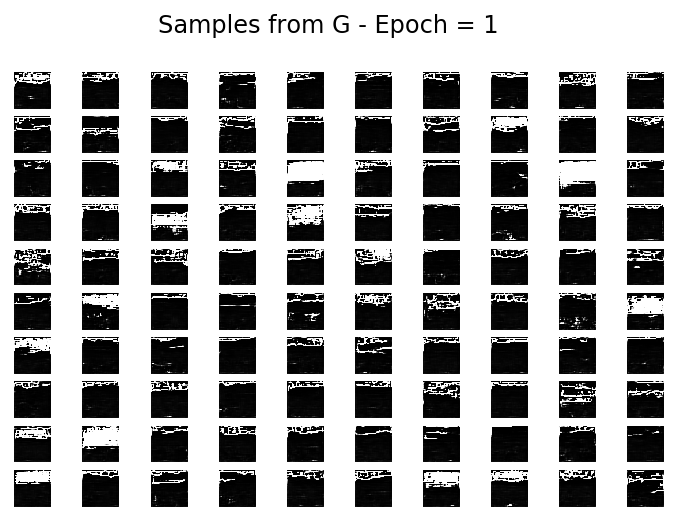

It cost :  247.33379101753235
It cost :  158.80592250823975
It cost :  158.28637886047363
It cost :  158.23443245887756
5  Acc =  0.77


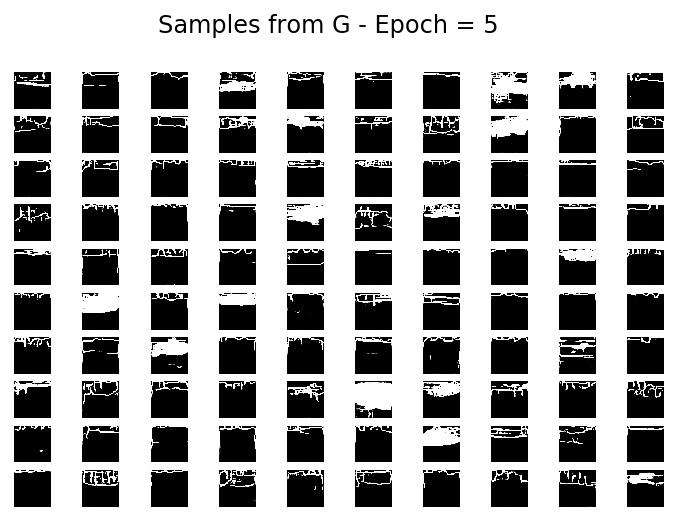

It cost :  163.3200135231018
It cost :  157.54086446762085
It cost :  157.37069439888
It cost :  157.64090180397034
It cost :  157.08909344673157
10  Acc =  0.86


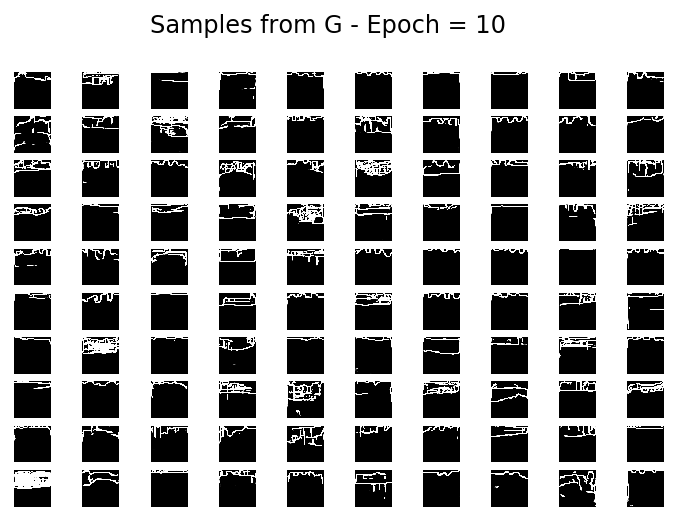

It cost :  162.21741032600403


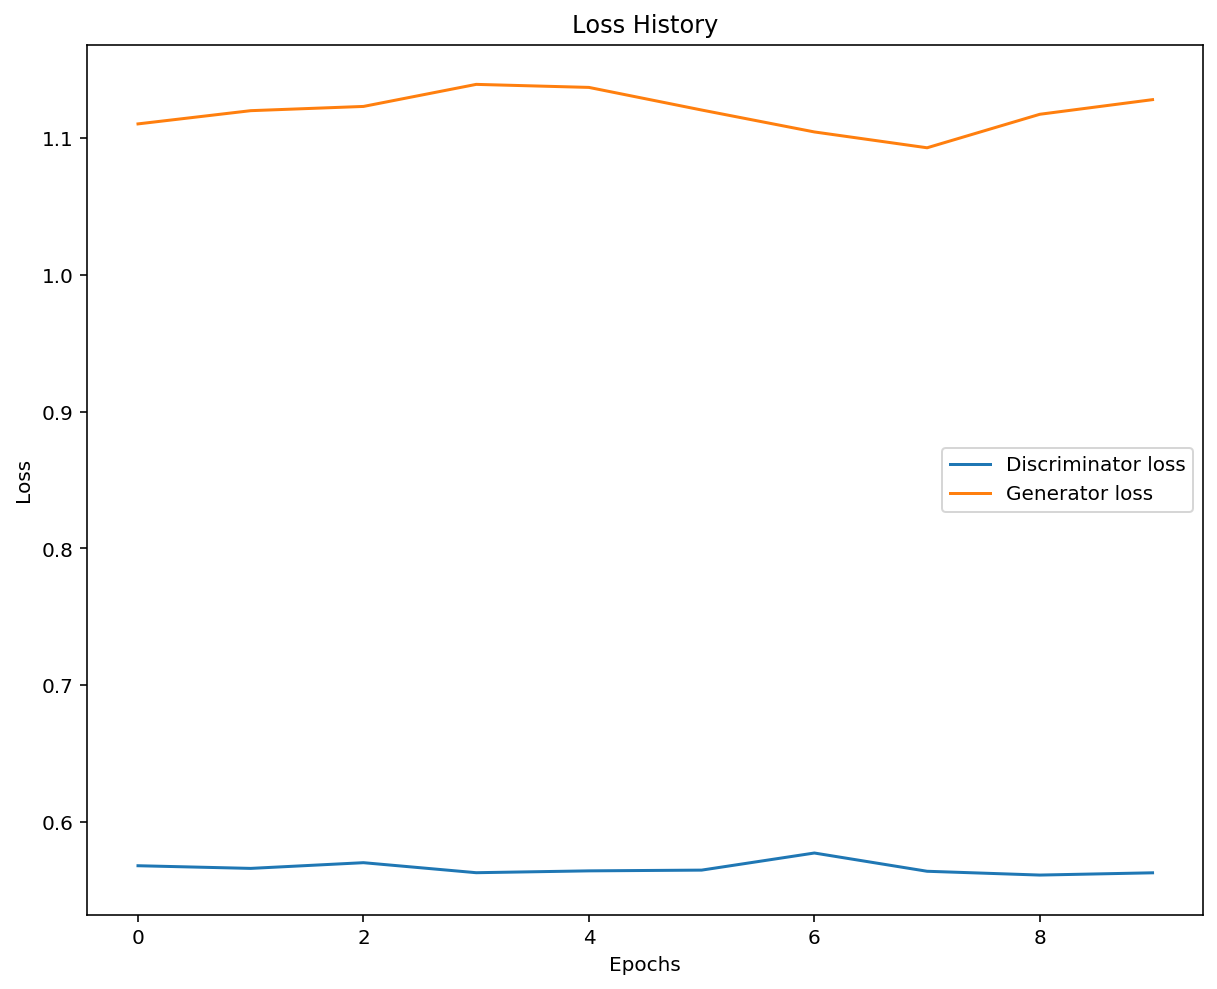

In [42]:
gan = DCGAN()
gan.train(X_train, epochs=10, batch_size=256, sample_interval=5)

In [0]:
gan.savemodel(0)